# Characterization of RFE

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import selector
from selector import energy_point_selector
from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [201]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [202]:
energy_point_selector = reload(selector.energy_point_selector)

In [246]:
N = 3
x = np.linspace(0, 50, 300)
mus = np.linspace(35, 45, N)
sigmas = np.array([mu / 50 for mu in mus])

def normal(x, mu, sig):
    return ( 1 / sig * np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ((x - mu) / sig)**2 )

basis = np.array([normal(x, mus[i], sigmas[i]) for i in range(len(mus))])
basis.shape

(3, 300)

In [247]:
noise = np.random.normal(scale=0.5 * basis + 0.05, size=basis.shape)
basis = basis + noise

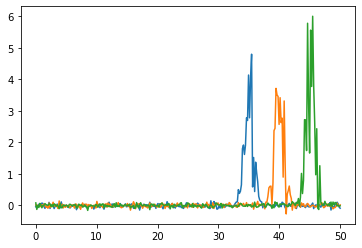

In [248]:
for b in basis:
    plt.plot(x, b)

In [258]:
N = 500
best_n = 100
reps = 30

Is = []
best_estimator = 'Linear Regression'
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.4, 'percent': False}
rfes = []
for i in range(reps):
    print(i + 1, end='\r')
    data, coeffs = generate_linear_combos(basis, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='r2')
    rfes.append(rfe)
    energy_measurements = x[rfe.support_]
    indices = [i for i, e in enumerate(x) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

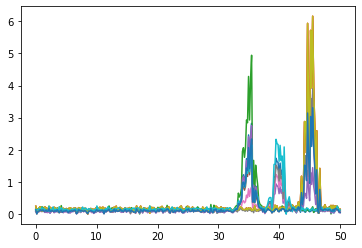

In [259]:
data, coeffs = generate_linear_combos(basis, **kwargs)
for i, d in enumerate(data):
    plt.plot(x, d)
    if i == 10:
        break

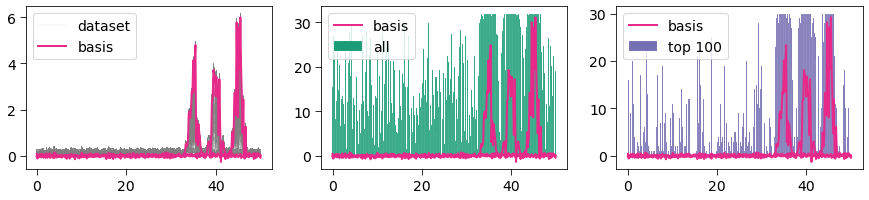

In [267]:
ranks = np.array([rfe.ranking_ for rfe in rfes], dtype=float)
res = x[1] - x[0]
bins = len(x)
hist, bvals = np.histogram(Is.reshape(-1), bins=bins, range=(0, len(x)))

fig, axes = plt.subplots(figsize=(15, 3), ncols=3)
data, coeffs = generate_linear_combos(basis, **kwargs)
for i, d in enumerate(data):
    if i == 0:
        label = 'dataset'
    else:
        label = None
    axes[0].plot(x, d, linewidth=0.1, c='gray', label=label)

scaled_ranks = np.sum(ranks, axis=0) / reps
importance = len(x) - scaled_ranks - np.min(len(x) - scaled_ranks)

axes[1].bar(x, importance, width=res, ec='w', linewidth=0.1,
            color=plt.cm.Dark2(0), label='all')
axes[2].bar(x, hist, width=res, linewidth=0.1, ec='w', color=plt.cm.Dark2(2),
            label=f'top {best_n}')
for i, b in enumerate(basis):
    if i == 0:
        label = 'basis'
    else:
        label = None
    axes[0].plot(x, b, linewidth=2, c=plt.cm.Dark2(3), label=label)
    axes[1].plot(x, b / axes[0].get_ylim()[1] * axes[1].get_ylim()[1], linewidth=2, 
                 c=plt.cm.Dark2(3), label=label)
    axes[2].plot(x, b / axes[0].get_ylim()[1] * axes[2].get_ylim()[1], linewidth=2, 
                 c=plt.cm.Dark2(3), label=label)
for ax in axes:
    ax.tick_params(length=6, labelsize=14)
    ax.legend(fontsize=14, loc=2)


N_estimators = 50
n = 1
n = 2
n = 3
n = 4


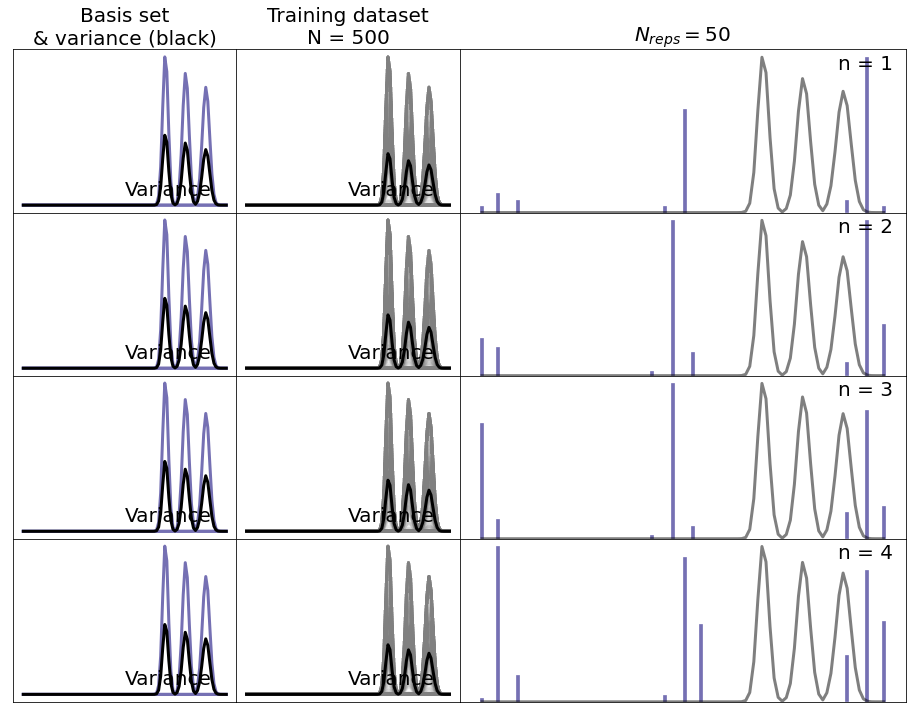

In [30]:
base_estimator = 'Linear Regression'
#base_estimator = 'Random Forest'

#scoring = 'neg_root_mean_squared_error'
scoring = 'r2'

Ns = np.arange(1, 5)
N = 500
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.4}
reps = 50

n_estimators = 50

colors = [plt.cm.Dark2(2) for i in range(3)]

print(f'\nN_estimators = {n_estimators}')
    
fig, axes = get_RFE_results(base_estimator, x, basis, Ns, reps, energy_point_selector, colors,
                            n_estimators=n_estimators, plot=True, select_n_for_me=False,
                            verbose=False, scoring=scoring, return_axes=True, **kwargs)
for axl in axes:
    for ax in axl:
        ax.set_yticks([])
        ax.set_xticks([])
        
fig.subplots_adjust(wspace=0, hspace=0)

In [31]:
base_estimator = 'Linear Regression'
#base_estimator = 'Random Forest'

#scoring = 'neg_root_mean_squared_error'
scoring = 'r2'

Ns = np.array([1, 2, 3])
N = 100
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.4}
reps = 10

num_estimators = [1]#[1, 10, 100]

colors = [plt.cm.tab20b(13), plt.cm.tab20b(17), plt.cm.tab20(12)]
S = []
for n_estimators in num_estimators:
    print(f'\nN_estimators = {n_estimators}')
    Scores = get_RFE_results(base_estimator, x, basis, Ns, reps, n_estimators=n_estimators,
                             plot=False, select_n_for_me=False,
                             scoring=scoring, **kwargs)
    Scores = np.array(Scores)
    S.append(Scores)
S = np.array(S)


N_estimators = 1


TypeError: get_RFE_results() missing 2 required positional arguments: 'energy_point_selector' and 'colors'

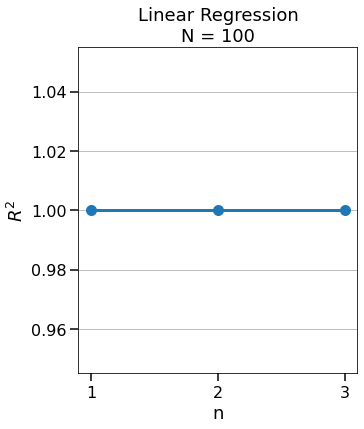

In [43]:
ncols = len(num_estimators)
if ncols == 1:
    fig, ax = plt.subplots(figsize=(5 * ncols, 6))
    plt.subplots_adjust(wspace=0.)
    Scores = S[0]
    plot_RFE_cv_scores((fig, ax), Scores, base_estimator, 1, N, scoring)
    ax.grid(axis='y')
    ax.set_xticks(Ns)
else:
    fig, axes = plt.subplots(figsize=(5 * ncols, 6), ncols=ncols)
    plt.subplots_adjust(wspace=0.)
    for i, Scores in enumerate(S):
        plot_RFE_cv_scores((fig, axes[i]), Scores, base_estimator, num_estimators[i], N,
                           scoring)
        ymin = np.min(np.average(S, axis=2))
        ymax = np.max(np.average(S, axis=2))
        dy = ymax - ymin
        axes[i].set_ylim(ymin - dy * 0.15, ymax + dy * 0.15)
        axes[i].grid(axis='y')
        axes[i].set_xticks(Ns)
        if i != 0:
            axes[i].set_ylabel(None)
            axes[i].yaxis.set_ticklabels([])
            axes[i].yaxis.set_ticks_position('none')            
plt.show()

# RFE on $\theta$ functions

In [133]:
utils = reload(utils)
from utils import *

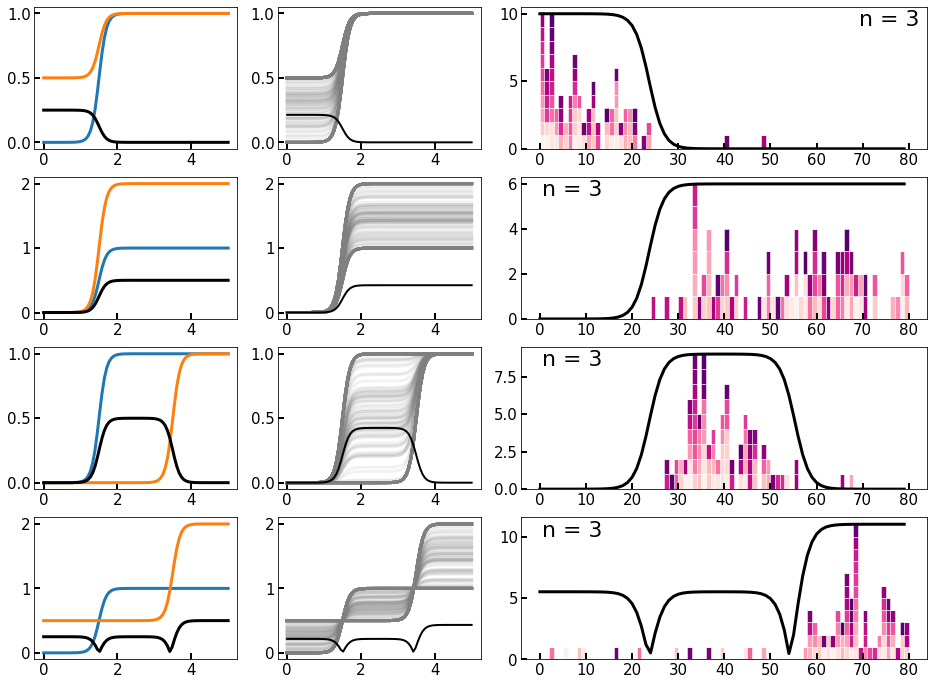

In [48]:
N = 2

def theta(x, a, b, c):
    return a + (b - a) * np.heaviside(x - c, b - a)

def sigmoid(x, a, b, c):
    return a + (b - a) / (1 + np.exp(-10 * (x - c)))

best_estimator = 'Linear Regression'
#best_estimator = 'Decision Tree'

scoring = 'neg_root_mean_squared_error'
#scoring = 'r2'

kwargs = {'N': 200, 'scale': 0.0, 'dropout': 0.5}
reps = 30
best_n = 3
colors = [plt.cm.tab10(i) for i in range(N)]

fig = plt.figure(figsize=(16, 12))
spec = fig.add_gridspec(ncols=3, nrows=4, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15, hspace=0.2)

function = sigmoid

if function == theta:
    A = np.linspace(0, 0.5, N)
    B = np.linspace(1, 2, N)
    C = np.linspace(1, 3, N)
    x = np.linspace(0, 4, 50)
elif function == sigmoid:
    A = np.linspace(0, 0.5, N)
    B = np.linspace(1, 2, N)
    C = np.linspace(1.5, 3.5, N)
    x = np.linspace(0, 5, 80)

for j in range(4):
    if j == 0:
        basis = np.array([function(x, A[i], B[0], C[0]) for i in range(N)])
    elif j == 1:
        basis = np.array([function(x, A[0], B[i], C[0]) for i in range(N)])
    elif j == 2:
        basis = np.array([function(x, A[0], B[0], C[i]) for i in range(N)])
    elif j == 3:
        basis = np.array([function(x, A[i], B[i], C[i]) for i in range(N)])
    
    Is = []
    for rep in range(reps):
        print(rep, end='\r')
        data, coeffs = generate_linear_combos(basis, **kwargs)

        select = energy_point_selector.Selector(data, coeffs)
        rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                          verbose=False, scoring=scoring)
        energy_measurements = x[rfe.support_]
        indices = [i for i, e in enumerate(x) if e in energy_measurements]
        Is.append(indices)
    Is = np.array(Is)
    
    indices = []
    
    axes = [fig.add_subplot(spec[j, k]) for k in range(3)]
    if j == 0:
        loc = 1
    else:
        loc = 2
    plot_RFE_results(axes, x, basis, indices, Is, best_n, colors, leg=False, loc=loc, **kwargs)

if function == sigmoid:
    plt.savefig(f'Figures/test_RFE_results_sigmoid.png', dpi=600, bbox_inches='tight')
elif function == theta:
    plt.savefig(f'Figures/test_RFE_results_heavyside.png', dpi=600, bbox_inches='tight')

## RFE on the Reference Set

In [111]:
base_estimator = 'Linear Regression'
#base_estimator = 'Random Forest'

Ns = np.arange(0, 26, 5)
Ns[0] = 1
reps = 10
scoring = 'r2'

S = []
populations = [50, 100, 150, 200, 300]

for N in populations:
    print(f"\nPopulation size = {N}")
    kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.8}
    Scores = []
    for best_n in Ns:
        scores = []
        print(f'best n = {best_n}')
        for i in range(reps):
            print(i, end='\r')
            data, coeffs = generate_linear_combos(Refs, **kwargs)

            select = energy_point_selector.Selector(data, coeffs)
            rfe, score = select.select_energy_points(estimator=base_estimator, n_points=best_n,
                                                     verbose=True, scoring=scoring)
            scores.append(score)
        Scores.append(scores)
    Scores = np.array(Scores)
    S.append(Scores)


Population size = 50
best n = 1
Score: 0.671 (0.128)
Score: 0.735 (0.119)
Score: 0.718 (0.130)
Score: 0.693 (0.132)
Score: 0.745 (0.115)
Score: 0.700 (0.129)
Score: 0.773 (0.120)
Score: 0.756 (0.123)
Score: 0.662 (0.121)
Score: 0.707 (0.125)
best n = 5
Score: 0.664 (0.108)
Score: 0.724 (0.121)
Score: 0.718 (0.106)
Score: 0.727 (0.116)
Score: 0.698 (0.107)
Score: 0.684 (0.126)
Score: 0.660 (0.103)
Score: 0.782 (0.104)
Score: 0.700 (0.117)
Score: 0.771 (0.141)
best n = 10
Score: 0.727 (0.109)
Score: 0.736 (0.120)
Score: 0.751 (0.123)
Score: 0.716 (0.125)
Score: 0.745 (0.116)
Score: 0.713 (0.130)
Score: 0.716 (0.127)
Score: 0.705 (0.107)
Score: 0.671 (0.119)
Score: 0.660 (0.106)
best n = 15
Score: 0.707 (0.142)
Score: 0.716 (0.119)
Score: 0.640 (0.121)
Score: 0.696 (0.132)
Score: 0.715 (0.126)
Score: 0.733 (0.099)
Score: 0.645 (0.117)
Score: 0.735 (0.101)
Score: 0.671 (0.118)
Score: 0.702 (0.121)
best n = 20
Score: 0.780 (0.126)
Score: 0.685 (0.124)
Score: 0.738 (0.107)
Score: 0.762 (0.1

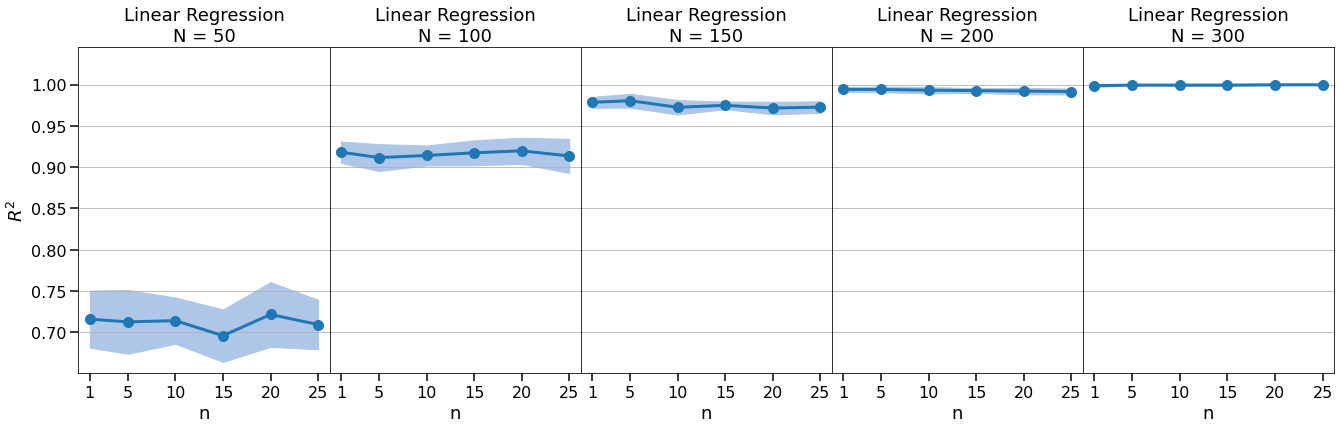

In [112]:
ncols = len(populations)
fig, axes = plt.subplots(figsize=(4.5 * ncols, 6), ncols=ncols)
plt.subplots_adjust(wspace=0.)

ymin = np.min(np.average(S, axis=2))
ymax = np.max(np.average(S, axis=2))
dy = ymax - ymin

for i, Scores in enumerate(S):
    plot_RFE_cv_scores((fig, axes[i]), Scores, base_estimator, 1, populations[i],
                        scoring)
    
    axes[i].set_ylim(ymin - dy * 0.15, ymax + dy * 0.15)
    axes[i].grid(axis='y')
    axes[i].set_xticks(Ns)
    if i != 0:
        axes[i].set_ylabel(None)
        axes[i].yaxis.set_ticklabels([])
        axes[i].yaxis.set_ticks_position('none')    